<a href="https://colab.research.google.com/github/projktapp/InstrumentosOpticos/blob/main/ProyectoOptico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn, jn_zeros

In [ ]:
def low_pass_filter(image, cutoff=0.2):

    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)

    #Ciclos por pizel
    rows, cols = image.shape
    freq_y = np.fft.fftfreq(rows)
    freq_x = np.fft.fftfreq(cols)
    fx, fy = np.meshgrid(freq_x, freq_y)

    #circulo de frequencias
    freq_radius = np.sqrt(fx**2 + fy**2)

    #mascara basa bjas
    mask = freq_radius <= cutoff

    F_filtered = F_shifted * mask
    F_inverse_shifted = np.fft.ifftshift(F_filtered)
    image_filtered = np.fft.ifft2(F_inverse_shifted)

    return image_filtered


In [ ]:
n_x = 2848
n_y = 2848
px_size = 2.74e-6

window_size = 1000


x = (np.arange(n_x) - n_x/2) * px_size
y = (np.arange(n_y) - n_y/2) * px_size

X, Y = np.meshgrid(x, y)

lam = 655e-9

f_number = 16
Difraction_limit = f_number*lam
Difraction_limit_px = Difraction_limit/px_size
maximum_freq_px = 1/Difraction_limit_px

print(Difraction_limit_px)
print(maximum_freq_px)



3.824817518248175
0.26145038167938933


In [ ]:
#deformacion gaussiana

peak_amplitude = 10* 655/2   #desplazamiento pico (nm)
sigma = 0.0015            # desviacion

# 4) Generate the 2D Gaussian
r_squared = X**2 + Y**2
gaussian_matrix = peak_amplitude * np.exp(-r_squared / (2 * sigma**2))

In [ ]:
# Piramide
peak_amplitude = 10 * 655 / 2  # peak displacement (nm)
L = 0.002                    # half the side-length of the pyramid's base (adjust as needed)

# Assuming X and Y are 2D arrays representing your grid coordinates
gaussian_matrix = peak_amplitude * np.maximum(0, 1 - np.maximum(np.abs(X), np.abs(Y)) / L)

In [ ]:
#modos circulares

peak_amplitude = 10* 655/2
r_squared = X**2 + Y**2
R = np.sqrt(r_squared)
a = 0.002

m = 1    # angular order
n = 1    # radial mode index

# Get the first zero of the Bessel function of order m
bessel_zero = jn_zeros(m, n)[-1]

# Compute the amplitude distribution using the Bessel function
gaussian_matrix = peak_amplitude*jn(m, bessel_zero * R / a)

# Enforce the boundary condition (zero amplitude for r > a)
gaussian_matrix[R > a] = 0

In [ ]:
#Modos cuadrados

m_square = 2
n_square = 3
a = 0.002
peak_amplitude = 10* 655/2


gaussian_matrix = peak_amplitude*(np.sin(m_square * np.pi * (X + a) / (2 * a)) * np.sin(n_square * np.pi * (Y + a) / (2 * a)))

mask = (np.abs(X) <= a) & (np.abs(Y) <= a)
gaussian_matrix[~mask] = 0


In [ ]:
displacement_range = 1e-9  # 1 nm

#asperidad superficie
neg_deltaX = 1000 * (np.random.rand(n_y, n_x) - 0.5)


desplazamientoGaussiana = (neg_deltaX + gaussian_matrix) * displacement_range  # convert the Gaussian to nm scale
desplazamientoAspero = neg_deltaX * displacement_range

# Δφ = - (2π / λ) * Δx

theta_0 = np.deg2rad(3)
R_1 = 50

phase_diff_gauss = - (2 * np.pi / lam) * desplazamientoGaussiana
phase_diff_aspero = - (2 * np.pi / lam) * desplazamientoAspero
phase_diff_speck = - (2 * np.pi / lam) * 1000 * (np.random.rand(n_y, n_x) - 0.5) * displacement_range

matrizCampoSpeckleRef = np.exp(1j * phase_diff_speck)
CampoRefSpeckFiltrado = low_pass_filter(matrizCampoSpeckleRef, 0.2)

phase_diff_sph_obj= (2 * np.pi / lam) * np.sin(theta_0) * X + (np.pi / (lam * R_1)) * ((np.cos(theta_0))**2 * X**2 + Y**2)



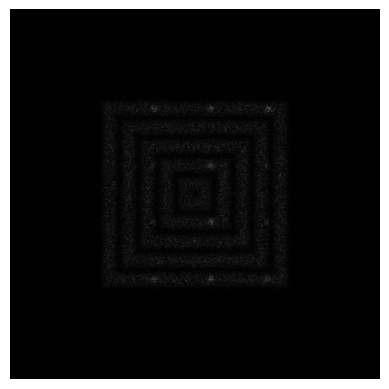

In [ ]:
#Diferencia de intensidad de interferencia con objeto deformado y objeto plano
#con referencia speckle

matrizCampoGauss = np.exp(1j * (phase_diff_gauss + phase_diff_sph_obj))
CampoObjetoDeformadoFiltrado = low_pass_filter(matrizCampoGauss, maximum_freq_px/4)

matrizCampoAspero = np.exp(1j *( phase_diff_aspero + phase_diff_sph_obj))
CampoObjetoPlanoFiltrado = low_pass_filter(matrizCampoAspero, maximum_freq_px/4)

#Intensidad interferencia objeto gauss y referencia plana
intObjRefSpeck = np.abs(CampoObjetoDeformadoFiltrado + CampoRefSpeckFiltrado)**2

#Intensidad interferencia objeto plano y referencia plana
intObjPlanRefSpeck = np.abs(CampoObjetoPlanoFiltrado + CampoRefSpeckFiltrado)**2

resta = np.abs(intObjRefSpeck - intObjPlanRefSpeck)


plt.imshow(resta,
           cmap='gray',
           #vmin=np.percentile(intObjRefSpeck, 15), vmax=np.percentile(intObjRefSpeck, 85),
           norm = 'linear',
           origin='lower',
           )

#plt.title("Intensidad interferencia objeto y referencia plana")
plt.axis('off')
#plt.savefig(r"/home/mamarinmo/Documents/Estudio/InstrumentosOpticos/resta.png", dpi=700, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:


for m in range(10):
  R_1 = 5/(10**m)
  print(R_1)

  phase_diff_sph_obj= (2 * np.pi / lam) * np.sin(theta_0) * X + (np.pi / (lam * R_1)) * ((np.cos(theta_0))**2 * X**2 + Y**2)

  matrizEsferica = np.exp(1j *phase_diff_sph_obj)

  imagEsf = np.angle(matrizEsferica)

  plt.imshow(imagEsf[1424 - window_size: 1424 + window_size,
                      1424 - window_size: 1424 + window_size],
            cmap='gray',
            norm = 'linear',
            origin='lower',
            )
  plt.colorbar()
  plt.axis('off')
  plt.show()





In [ ]:
for m in range(10):
  R_1 = 5/(10**m)
  print(R_1)


  phase_diff_sph_obj= (2 * np.pi / lam) * np.sin(theta_0) * X + (np.pi / (lam * R_1)) * ((np.cos(theta_0))**2 * X**2 + Y**2)


  matrizCampoGauss = np.exp(1j * (phase_diff_gauss + phase_diff_sph_obj))
  CampoObjetoDeformadoFiltrado = low_pass_filter(matrizCampoGauss, maximum_freq_px)


  matrizCampoAspero = np.exp(1j *( phase_diff_aspero + phase_diff_sph_obj))
  CampoObjetoPlanoFiltrado = low_pass_filter(matrizCampoAspero, maximum_freq_px)

    #Intensidad interferencia objeto gauss y referencia plana
  intObjRefSpeck = np.abs(CampoObjetoDeformadoFiltrado + CampoRefSpeckFiltrado)**2

  #Intensidad interferencia objeto plano y referencia plana
  intObjPlanRefSpeck = np.abs(CampoObjetoPlanoFiltrado + CampoRefSpeckFiltrado)**2

  resta = np.abs(intObjRefSpeck - intObjPlanRefSpeck)


  plt.imshow(intObjRefSpeck[1424 - window_size: 1424 + window_size,
                      1424 - window_size: 1424 + window_size],
            cmap='gray',
            #vmin=np.percentile(intObjRefSpeck, 15), vmax=np.percentile(intObjRefSpeck, 85),
            norm = 'linear',
            origin='lower',
            )

  #plt.title("Intensidad interferencia objeto y referencia plana")
  plt.axis('off')
  #plt.savefig(r"/home/mamarinmo/Documents/Estudio/InstrumentosOpticos/resta.png", dpi=700, bbox_inches='tight', pad_inches=0)
  plt.show()

  plt.imshow(intObjPlanRefSpeck[1424 - window_size: 1424 + window_size,
                      1424 - window_size: 1424 + window_size],
            cmap='gray',
            #vmin=np.percentile(intObjRefSpeck, 15), vmax=np.percentile(intObjRefSpeck, 85),
            norm = 'linear',
            origin='lower',
            )

  #plt.title("Intensidad interferencia objeto y referencia plana")
  plt.axis('off')
  #plt.savefig(r"/home/mamarinmo/Documents/Estudio/InstrumentosOpticos/resta.png", dpi=700, bbox_inches='tight', pad_inches=0)
  plt.show()